In [45]:
# Import necessary modules

import pandas as pd
import numpy as np
from tqdm import tqdm
import os
from pathlib import Path
import xarray as xr
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from datetime import datetime
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import matplotlib.colors as colors
import geopandas as gpd
from urllib.request import urlretrieve
import requests
from glob import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
from pathlib import Path
from datetime import datetime, timedelta
import json
import sys
import math
from geopy.distance import distance
from matplotlib.colors import to_rgba
from collections import defaultdict

In [46]:
# Establish directory locations

parent_dir    = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir      = os.path.join(parent_dir, 'data')
satellite_dir = os.path.join(data_dir, 'satellite')
output_dir    = os.path.join(parent_dir, 'Output/sat_plot')
NEODASS_dir   = os.path.join(satellite_dir, 'NEODASS')
floats_dir    = os.path.join(parent_dir, 'Data/Floats')


In [47]:
# Plotting preferences

# Global
min_lon = -27 #-35
max_lon = -20 #-5
min_lat = 58.5 #55
max_lat = 63 #66

additional_suffix = 'TEST'

# Float colors
# For additional floats, add the name (as it appears in the 'Float_positions.csv') and color you'd like (as a hexcode)
float_colors = {
        '4903532':  '#B4184C',
        'navis102': '#F5A300',
        '1902637':  '#0000E0',
        'navis101': '#FBFF1F'}


# CHLA
CHLA_color           = 'YlGnBu_r'
CHLA_plot_as_log     = True # Default True
CHLA_plot_lim_max    = 10   # Default 10
CHLA_plot_lim_min    = 0.1  # Default 0.1

# SST
SST_color            = 'YlOrRd'
SST_plot_as_log      = False # Default False
SST_plot_lim_max     = 15    # Default 15
SST_plot_lim_min     = 5     # Default 5

# SSH
SSH_color            = 'RdBu'
SSH_plot_as_log      = False # Default False
SSH_plot_lim_max     = 0.5   # Default  0.5
SSH_plot_lim_min     = -0.5  # Default -0.5

# Surface Currents
SSC_color            = 'YlGnBu_r'
SSC_plot_as_log      = False # Default False
SSC_plot_lim_max     = 5   # Default 5
SSC_plot_lim_min     = 0   # Default 0

# BBP
BBP_color            = 'YlGnBu_r'
BBP_plot_as_log      = True
BBP_plot_lim_max     = 0.1
BBP_plot_lim_min     = 0.0001

# PIC
skip_pic             = False
PIC_color            = 'YlGnBu_r'
PIC_plot_as_log      = True
PIC_plot_lim_max     = 0.1
PIC_plot_lim_min     = 0.0000001

In [48]:
# Function to generate points on a circle centered at (lat, lon) with a given radius
def generate_circle_points(lat, lon, radius_km, num_points=360):
    angles = np.linspace(0, 360, num_points)
    circle_points = []
    for angle in angles:
        point = distance(kilometers=radius_km).destination((lat, lon), angle)
        circle_points.append((point.latitude, point.longitude))
    
    return np.array(circle_points)

In [49]:
### Plotting most recent data from CMEMS
## List most recent files

# List to store matching file names
matching_files = []

# Loop through the files in the directory
for filename in os.listdir(satellite_dir):
    if filename.endswith('.nc'):
        matching_files.append(filename)

print(matching_files)

## List variables from these files
# Dictionary to store files by their base names (excluding '_a_' or '_b_') and key variables
file_dict = {}

for file in matching_files:
    # Identify the base name by removing '_a' or '_b' if present
    base_name = file.replace('_a', '_').replace('_b', '_')
    if base_name not in file_dict:
        file_dict[base_name] = {}
    filepath = os.path.join(satellite_dir, file)
    ds = xr.open_dataset(filepath)
    variables = list(ds.data_vars.keys())

    print(file)
    print(variables)

    key_variables = [var for var in variables if 'longitude' not in var.lower() and 'latitude' not in var.lower()]

    if key_variables:
        for key_variable in key_variables:
            if file not in file_dict[base_name]:
                file_dict[base_name][file] = {}
            file_dict[base_name][file][key_variable] = {
                'variable': key_variable,
            }
    else:
        print(f"No suitable key variable found in file: {file}")

    ds.close()

# Print the results
#for base_name, files in file_dict.items():
#    for file, key_variable in files.items():
#        print(f'File: {file}')
#        print(f'Base Name: {base_name}')
#        print(f'Key Variable: {key_variable}')
#
#    filepath  = os.path.join(satellite_dir, file)
#    dataset = xr.open_dataset(filepath)
#
#    # Print global attributes
#    print("Global attributes:")
#    for attr_name, attr_value in dataset.attrs.items():
#        print(f"  {attr_name}: {attr_value}")
#
#    # Print variable attributes
#    print("\nVariable attributes:")
#    for var_name, var in dataset.variables.items():
#        print(f"Variable: {var_name}")
#        for attr_name, attr_value in var.attrs.items():
#            print(f"  {attr_name}: {attr_value}")

# Initialize var_dict with categories as keys and empty dictionaries as values
var_dict = {'chl': {}, 'temp': {}, 'sla': {}, 'adt': {}, 'bbp': {}, 'dissic': {}}

for base_name, files in file_dict.items():
    for file, variables in files.items():
        for key_variable, details in variables.items():
            data_var = details['variable']
            var_name_lower = data_var.lower()
            print(data_var)
            if 'chl' in var_name_lower and var_name_lower == 'chl':
                var_dict['chl'][file] = data_var
            elif 'temp' in var_name_lower:
                var_dict['temp'][file] = data_var
            elif 'sla' in var_name_lower:
                var_dict['sla'][file] = data_var
            elif 'adt' in var_name_lower:
                var_dict['adt'][file] = data_var
            elif 'bbp' in var_name_lower and var_name_lower == 'bbp':
                var_dict['bbp'][file] = data_var
            elif 'dissic' in var_name_lower and var_name_lower == 'dissic':
                var_dict['dissic'][file] = data_var

# We load shape files for bathymetry lines
#first_line_path = 'c:\\Users\\flapet\\OneDrive - NOC\\Documents\\NRT_viz\\biocarbon_nrt_data_viz/Data/ne_10m_bathymetry_all/ne_10m_bathymetry_J_1000.shp'
#second_line_path = 'c:\\Users\\flapet\\OneDrive - NOC\\Documents\\NRT_viz\\biocarbon_nrt_data_viz/Data/ne_10m_bathymetry_all/ne_10m_bathymetry_I_2000.shp'

first_line_path  = 'C:\\Users\\hanshil\\Documents\\GitHub\\biocarbon_nrt_data_viz\\data\\bathymetry\\ne_10m_bathymetry_J_1000.shp'
second_line_path = 'C:\\Users\\hanshil\\Documents\\GitHub\\biocarbon_nrt_data_viz\\data\\bathymetry\\ne_10m_bathymetry_I_2000.shp'

gdf_1000 = gpd.read_file(first_line_path)
gdf_2000 = gpd.read_file(second_line_path)

['CMEMS_cmems_mod_glo_bgc-car_anfc_0.25deg_P1D-m_April-May2024.nc', 'CMEMS_cmems_obs-oc_atl_bgc-optics_nrt_l3-multi-1km_P1D_April-May2024.nc', 'CMEMS_cmems_obs-oc_atl_bgc-plankton_nrt_l3-multi-1km_P1D_April-May2024.nc', 'CMEMS_cmems_obs-sl_eur_phy-ssh_nrt_allsat-l4-duacs-0.125deg_P1D_April-May2024.nc']
CMEMS_cmems_mod_glo_bgc-car_anfc_0.25deg_P1D-m_April-May2024.nc
['dissic', 'ph', 'talk']
CMEMS_cmems_obs-oc_atl_bgc-optics_nrt_l3-multi-1km_P1D_April-May2024.nc
['BBP', 'BBP_uncertainty', 'CDM', 'CDM_uncertainty', 'flags']
CMEMS_cmems_obs-oc_atl_bgc-plankton_nrt_l3-multi-1km_P1D_April-May2024.nc
['CHL', 'CHL_uncertainty', 'DIATO', 'DIATO_uncertainty', 'DINO', 'DINO_uncertainty', 'GREEN', 'GREEN_uncertainty', 'HAPTO', 'HAPTO_uncertainty', 'MICRO', 'MICRO_uncertainty', 'NANO', 'NANO_uncertainty', 'PICO', 'PICO_uncertainty', 'PROCHLO', 'PROCHLO_uncertainty', 'PROKAR', 'PROKAR_uncertainty', 'flags']
CMEMS_cmems_obs-sl_eur_phy-ssh_nrt_allsat-l4-duacs-0.125deg_P1D_April-May2024.nc
['adt', 'err

  0%|          | 0/6 [00:00<?, ?it/s]

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
chl
[[       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan 0.75445616 0.74997497]]
chl


 17%|█▋        | 1/6 [01:06<05:30, 66.12s/it]

[[ 0.0081 -0.0036 -0.0146 ...  0.2241  0.2248  0.2242]
 [ 0.0037 -0.0047 -0.0109 ...  0.0793  0.072   0.0639]
 [-0.0021 -0.0059 -0.0077 ...  0.0723  0.0653  0.0579]
 ...
 [ 0.0081  0.0197  0.0265 ...  0.0298  0.0292  0.0287]
 [-0.0066  0.006   0.0118 ...  0.0277  0.0276  0.0276]
 [-0.0284 -0.0188 -0.0163 ...  0.0254  0.0254  0.0255]]
sla
[[ 0.0111  0.0006 -0.0069 ...  0.212   0.2122  0.2114]
 [ 0.0058 -0.0018 -0.0068 ...  0.0841  0.0791  0.0737]
 [-0.0003 -0.0039 -0.0062 ...  0.0785  0.0738  0.069 ]
 ...
 [-0.0385 -0.0306 -0.0258 ...  0.0325  0.0313  0.0304]
 [-0.062  -0.0537 -0.0439 ...  0.0348  0.0341  0.0335]
 [-0.0832 -0.0772 -0.0638 ...  0.0366  0.0358  0.0351]]
sla


 50%|█████     | 3/6 [01:49<01:40, 33.37s/it]

[[-0.4532 -0.459  -0.4656 ...  0.1993  0.2011     nan]
 [-0.4582 -0.4607 -0.4614 ...  0.0534  0.0469     nan]
 [-0.4652 -0.4629 -0.4591 ...  0.0464  0.0401     nan]
 ...
 [-0.284  -0.2743 -0.2696 ... -0.4319 -0.4327 -0.4335]
 [-0.2907 -0.2756 -0.2689 ... -0.4364 -0.4363 -0.4362]
 [-0.3074 -0.2908 -0.2821 ... -0.4458 -0.4453 -0.4445]]
adt
[[-0.4502 -0.4548 -0.4579 ...  0.1872  0.1885     nan]
 [-0.4561 -0.4578 -0.4572 ...  0.0583  0.054      nan]
 [-0.4633 -0.4609 -0.4575 ...  0.0526  0.0486     nan]
 ...
 [-0.3305 -0.3246 -0.322  ... -0.4292 -0.4306 -0.4317]
 [-0.346  -0.3353 -0.3246 ... -0.4293 -0.4298 -0.4302]
 [-0.3622 -0.3491 -0.3296 ... -0.4346 -0.4349 -0.4349]]
adt


 67%|██████▋   | 4/6 [02:46<01:23, 41.51s/it]

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
bbp
[[       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan 0.01094405 0.01094405]]
bbp


 83%|████████▎ | 5/6 [03:52<00:46, 46.48s/it]

[[[2.1705148 2.1707368 2.170374  ... 2.0889075 2.0841475       nan]
  [2.1714015 2.1715655 2.1714706 ... 2.0758197 2.0731165 2.0650742]
  [2.1717126 2.172086  2.1722271 ... 2.0679553 2.0643926 2.066369 ]
  ...
  [2.1599936 2.1610653 2.1632476 ... 2.1628742 2.1619399 2.1615696]
  [2.1576772 2.1573758 2.157473  ... 2.1652324 2.1647704 2.1637895]
  [2.1586444 2.158206  2.1580508 ... 2.1647806 2.1641002 2.1629148]]]
dissic


TypeError: Dimensions of C (1, 45, 121) should be one smaller than X(121) and Y(45) while using shading='flat' see help(pcolormesh)

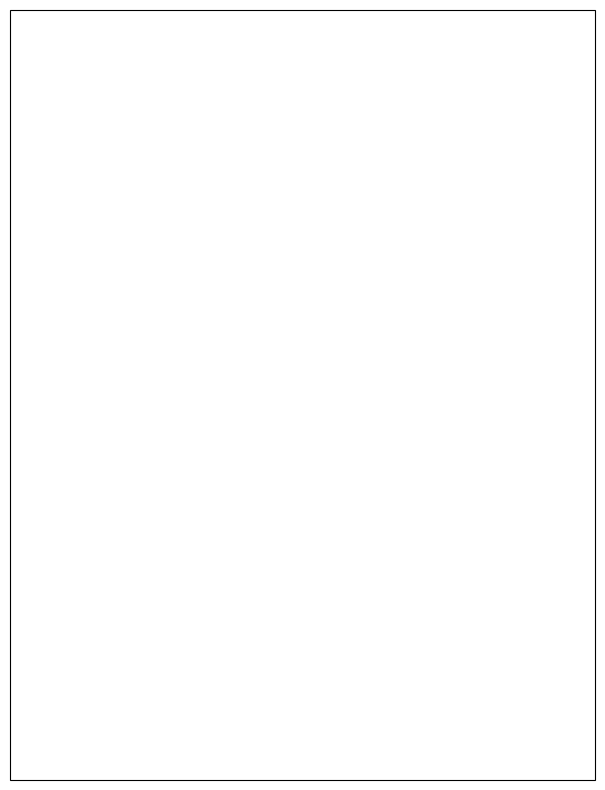

In [53]:
# Plotting loop

# 130km circle around deploy point
circle_points = generate_circle_points(60, -24, 444)
circle_lats, circle_lons = circle_points[:, 0], circle_points[:, 1]

# Load float positions
float_position_path = os.path.join(floats_dir, 'Float_positions_2024_05_25.csv')
full_position = pd.read_csv(float_position_path)

for var_category, files in tqdm(var_dict.items()):
    for day_offset in [-2, -1]:  # Plot the last two days
        if len(files) > 1:
            data_vars = []
            for file, data_var in files.items():
                cur_data_var = xr.open_dataset(os.path.join(satellite_dir, file))
                data_vars.append(cur_data_var[data_var].isel(time=day_offset))
            aligned_data_vars = xr.align(*data_vars, join='outer')
            combined_data_var = aligned_data_vars[0]
            for var in aligned_data_vars[1:]:
                combined_data_var = combined_data_var.combine_first(var)
            combined_data_var_mean = np.nanmean(combined_data_var, axis=0)
            date_of_plot = str(combined_data_var['time'].data[0])[0:10]
        elif len(files) == 1:
            file, data_var = next(iter(files.items()))
            cur_data_var = xr.open_dataset(os.path.join(satellite_dir, file))
            date_of_plot = str(cur_data_var['time'].data[day_offset])[0:10]
            combined_data_var_mean = cur_data_var[data_var].isel(time=day_offset).data
        else:
            continue

        # Dependant settings based on each variable type
        if var_category == 'chl':
            xx_plot_units = cur_data_var[data_var].attrs.get('units')
            xx_plot_cbar_label = 'Chlorophyll (' + xx_plot_units + ')'
            xx_plot_min = CHLA_plot_lim_min
            xx_plot_max = CHLA_plot_lim_max
            color = CHLA_color
            log_scaling = CHLA_plot_as_log
            xx_output_dir_name = 'Chla'

        elif var_category == 'temp':
            xx_plot_units = cur_data_var[data_var].attrs.get('units')
            if xx_plot_units == 'kelvin':
                degree_sign = u'\N{DEGREE SIGN}'
                xx_plot_cbar_label = 'Sea Surface Temperature (' + degree_sign + 'C)'
                if len(files) > 1:
                    combined_data_var_mean -= 273.15
                else:
                    cur_data_var[data_var] = cur_data_var[data_var] - 273.15
                xx_plot_min = SST_plot_lim_min
                xx_plot_max = SST_plot_lim_max
                color = SST_color
                log_scaling = SST_plot_as_log
                xx_output_dir_name = 'SST'
                
        elif var_category == 'sla':
            xx_plot_units = cur_data_var[data_var].attrs.get('units')
            xx_plot_cbar_label = 'Sea level anomaly (' + xx_plot_units + ')'
            xx_plot_min = SSH_plot_lim_min
            xx_plot_max = SSH_plot_lim_max
            color = SSH_color
            log_scaling = SSH_plot_as_log
            xx_output_dir_name = 'SLA'

        elif var_category == 'adt':
            xx_plot_units = cur_data_var[data_var].attrs.get('units')
            xx_plot_cbar_label = 'Sea surface velocity (' + xx_plot_units + 's$^{-1}$)'
            xx_plot_min = SSH_plot_lim_min
            xx_plot_max = SSH_plot_lim_max
            color = SSH_color
            log_scaling = SSH_plot_as_log
            xx_output_dir_name = 'SSC'

        elif var_category == 'bbp':
            xx_plot_units = cur_data_var[data_var].attrs.get('units')
            xx_plot_cbar_label = 'Particulate backscatter (' + xx_plot_units + ')'
            xx_plot_min = BBP_plot_lim_min
            xx_plot_max = BBP_plot_lim_max
            color = BBP_color
            log_scaling = BBP_plot_as_log
            xx_output_dir_name = 'BBP'

        elif var_category == 'dissic':
            xx_plot_units = cur_data_var[data_var].attrs.get('units')
            xx_plot_cbar_label = 'PIC (' + xx_plot_units + ')'
            xx_plot_min = PIC_plot_lim_min
            xx_plot_max = PIC_plot_lim_max
            color = PIC_color
            log_scaling = PIC_plot_as_log
            xx_output_dir_name = 'PIC'

        print(combined_data_var_mean)
        print(var_category)
        
        norm = colors.LogNorm(vmin=xx_plot_min, vmax=xx_plot_max) if log_scaling else colors.Normalize(vmin=xx_plot_min, vmax=xx_plot_max)
        NEODASS_data_to_plot_1day = np.clip(combined_data_var_mean, xx_plot_min, xx_plot_max)

        if var_category == 'adt':
            
            if min_lon < -30:
                adt_min_lon = min_lon
            else:
                adt_min_lon = -30

            fig = plt.figure(figsize=(15, 15))
            ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
            ax.set_extent([adt_min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

            # Extract the lon and lat from the dataset only once
            x = cur_data_var['longitude'].data
            y = cur_data_var['latitude'].data

            #From the U and V vector compute the speed, we use it as our colour map
            u = cur_data_var['ugos'].isel(time=day_offset).data
            v = cur_data_var['vgos'].isel(time=day_offset).data
            speed = np.sqrt(u**2 + v**2)

            #Plot the current vectors field and the coastline
            im = ax.quiver(x, y, u, v, speed, angles='xy', scale_units='xy', cmap='viridis', transform=ccrs.PlateCarree(), regrid_shape=50, width = 0.002)

            cbar = plt.colorbar(im, ax=ax, label=xx_plot_cbar_label)

        else:

            fig = plt.figure(figsize=(20, 10))
            ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
            ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
            
            im = ax.pcolormesh(cur_data_var['longitude'].data, 
                               cur_data_var['latitude'].data, 
                               NEODASS_data_to_plot_1day, 
                               cmap=color, 
                               norm=norm,
                               transform=ccrs.PlateCarree())
        
            cbar = plt.colorbar(im, ax=ax, label=xx_plot_cbar_label)

        # Float plotting section
        # Get the unique float names
        unique_floats = full_position['float'].unique()

        # Store legend handles and labels
        legend_handles = []
        
        # Plot each float's positions
        for float_name in unique_floats:
            float_data = full_position[full_position['float'] == float_name].sort_values(by='JULD', ascending=False)  # Sort in descending order

            # Get the colors and opacities for the points
            rgba_color = to_rgba(float_colors.get(float_name, '#000000'))  # Default to black if not found
            num_positions = len(float_data)
            alphas = np.linspace(1, 0.1, min(num_positions, 9))  # Reverse the opacity gradient

            # Plot the positions and lines, with the first 9 points have a decreasing alpha
            for i, (index, row) in enumerate(float_data.iterrows()):
                alpha = alphas[i] if i < 9 else 0.1
                rgba_color_with_alpha = (*rgba_color[:3], alpha)
                marker_edge_color     = (*rgba_color[:3], alpha)  # Marker edge color follows opacity gradient
                ax.scatter(row['LONGITUDE'], row['LATITUDE'], color=rgba_color_with_alpha, edgecolor=marker_edge_color, transform=ccrs.PlateCarree(), zorder=3)

                if i > 0:
                    prev_row = float_data.iloc[i - 1]
                    ax.plot([prev_row['LONGITUDE'], row['LONGITUDE']],
                            [prev_row['LATITUDE'], row['LATITUDE']],
                            color=rgba_color_with_alpha, transform=ccrs.PlateCarree(), zorder=2)
                    
            # Create a proxy artist for each float
            proxy = plt.Line2D([0], [0], linestyle='-', marker='o', color=float_colors.get(float_name, '#000000'), label=float_name)
            legend_handles.append(proxy)
        
        sc3 = ax.scatter(-24,60,transform=ccrs.PlateCarree(), edgecolors='black', facecolors='none', marker='s')
        ax.plot(circle_lons, circle_lats, transform=ccrs.PlateCarree(), color='black')
        
        gdf_1000.plot(ax=ax, transform=ccrs.PlateCarree(), linewidth=0.5, edgecolor='k', facecolor='none')
        gdf_2000.plot(ax=ax, transform=ccrs.PlateCarree(), linewidth=0.3, edgecolor='k', facecolor='none')

        # Add coastlines
        ax.add_feature(cfeature.COASTLINE)

        # Add lon/lat grid and adjust labels
        gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, crs=ccrs.PlateCarree())
        gl.top_labels = False
        gl.right_labels = False

        # Plot title
        plot_title = f'CMEMS_{xx_output_dir_name} {date_of_plot}'
        ax.set_title(plot_title, fontsize=24)

        # Add legend in
        deploy_point_proxy = plt.Line2D([0], [0], linestyle='none', marker='s', color='black', markersize=10, markerfacecolor='none', label='Deploy Point')
        legend_handles.append(deploy_point_proxy)
        ax.legend(handles=legend_handles, loc='lower left')

        # Save output
        save_dir = os.path.join(output_dir, f'{xx_output_dir_name}{"_log" if log_scaling else ""}{additional_suffix}')
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        filename = f'{xx_output_dir_name}{"_log" if log_scaling else ""}_{date_of_plot}_CMEMS.png'
        plt.savefig(os.path.join(save_dir, filename))
        
        plt.clf()
        plt.close()